In [12]:
import numpy as np
import cv2
import glob
import pickle
import sys
from collections import defaultdict, Counter
import caffe
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [2]:
files = glob.glob('./*.avi')

In [3]:
file_a, file_b = files

In [4]:
extract_from_layer = "pool5/7x7_s1"
model_def= "./deploy.prototxt"
pretrained_model="./bvlc_googlenet.caffemodel"

net = caffe.Net(model_def, pretrained_model, caffe.TEST)

In [6]:
def read_video(file_name):
    vidcap = cv2.VideoCapture(file_name)
    final_arr = []
    frame_num = 0

    while frame_num < round(vidcap.get(cv2.CAP_PROP_FPS)) * 5 * 60:
        sys.stdout.write("\r%d%%" % frame_num)
        sys.stdout.flush()
        frame_num += 1
        
        ret, image = vidcap.read()
        img =  cv2.resize(image, (224, 224)) 
        img = np.array(img,dtype=float)
        features = np.zeros(1024,)
        img[:,:,[0,1,2]] = img[:, :, [2, 1, 0]] # swap channels
        img = img.transpose((2, 0, 1)) # re-order dimensions

        net.blobs['data'].reshape(1,3,224,224)
        net.blobs['data'].data[...] = img
        res = net.forward()
        
        final_arr.append(np.ndarray.flatten(net.blobs['pool5/7x7_s1'].data[0].copy()))
    return final_arr

videogen_a = read_video(file_a)

7199%

In [7]:
videogen_b = read_video(file_b)

7199%

In [8]:
print (file_a, file_b)
import sys
sys.getsizeof(videogen_a)

('./House MD 202 - Autopsy.avi', './House MD 203 - Humpty Dumpty.avi')


61440

In [9]:
import pickle
outfile = open('videogen_a.pkl', 'wb')
pickle.dump([videogen_a, videogen_b],outfile)
outfile.close()

In [5]:
import pickle
infile = open('videogen_a.pkl', 'rb')
videogen_a, videogen_b = pickle.load(infile)
infile.close()

In [7]:
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(videogen_a)

In [34]:
distance, indices = nbrs.kneighbors(videogen_b)
temp = [i/24 for i in indices]

array([ 30, 156])

In [50]:
dp = [1 for i in range(len(temp))]
l = [min(i) for ind, i in enumerate(temp)]
from scipy.signal import savgol_filter
l = savgol_filter(l, 51, 1)

In [51]:
for i in range(1, len(l)):
    if abs(l[i] - l[i-1]) < 2:
        dp[i] = dp[i-1] + 1

In [52]:
import operator
index, value = max(enumerate(dp), key=operator.itemgetter(1))
print index/24, (index-value)/24

161 128


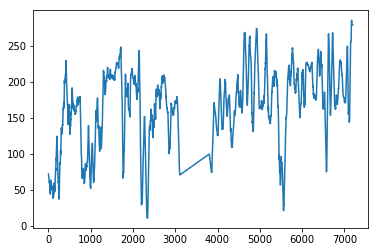

<Figure size 432x288 with 0 Axes>

In [54]:
plt.plot(l)
plt.show()
plt.savefig('temp.png')

In [59]:
house_intro = np.array(videogen_b[index-value:index])
house_intro_len = value